In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

import os
import shutil

from google.colab import files
uploaded = files.upload()

Saving data_zif8.xlsx to data_zif8.xlsx


In [38]:
# Set random seeds for reproducibility
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Extract actual data of input varialbes
Xall = pd.read_excel('data_zif8.xlsx')
# print(Xall.columns)

X = Xall[['Hmim', 'Temp', 'Viscosity', 'Density', 'Polarity']]

'''
# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)
'''

# Extract the dependent variable
y = Xall['DependentVariable']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)

In [3]:
# Optimize hyperparameters of the Random forest model

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
from sklearn.utils import resample

# Create a Random Forest Regressor
rf_model = RandomForestRegressor()


# Define the parameter grid for GridSearchCV
# This set of parameters try smaller values for each
param_grid = {
    'n_estimators': [5, 10, 15, 20, 25, 30],  # Adjust as needed
    'max_depth': [None, 5, 10, 20],  # Adjust as needed
    'min_samples_split': [2, 3, 5], # [2, 5, 10]
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create GridSearchCV object
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='r2', verbose = 1)

# Fit the model to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

print(f"Best hyperparameters: {best_params}")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best hyperparameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 5}


In [4]:
# Use the best hyperparameters obtained from the grid search

best_n_estimators = best_params['n_estimators']
best_max_depth = best_params['max_depth']
best_min_samples_split = best_params['min_samples_split']
best_min_samples_leaf = best_params['min_samples_leaf']
#best_max_features = best_params['max_features']
best_bootstrap = best_params['bootstrap']

# Create a new instance of RandomForestRegressor with the best hyperparameters
best_rf_model = RandomForestRegressor(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    # max_features=best_max_features,
    max_features=1.0,
    bootstrap=best_bootstrap
)

# Fit the model to the training data
best_rf_model.fit(X_train, y_train)

# Make predictions on training data
y_pred_rfT = best_rf_model.predict(X_train)

# Evaluate the model on testing data
r_squaredT = r2_score(y_train, y_pred_rfT)
mseT = mean_squared_error(y_train, y_pred_rfT)

print(f"r_squared on training data: {r_squaredT}")
print(f"MSE on training data: {mseT}")

# Make predictions on testing data
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate the model on testing data
r_squared = r2_score(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)

print(f"r_squared on testing data: {r_squared}")
print(f"MSE on testing data: {mse}")

r_squared on training data: 0.9714828820899154
MSE on training data: 57.16422395833333
r_squared on testing data: 0.8838706949578061
MSE on testing data: 190.09163950000013


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


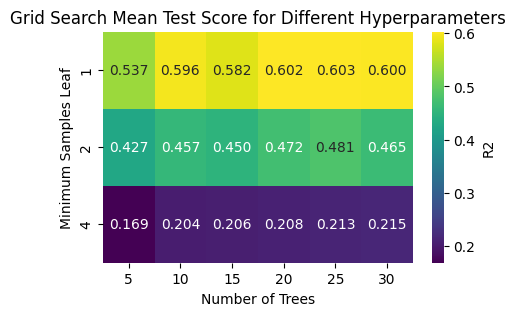

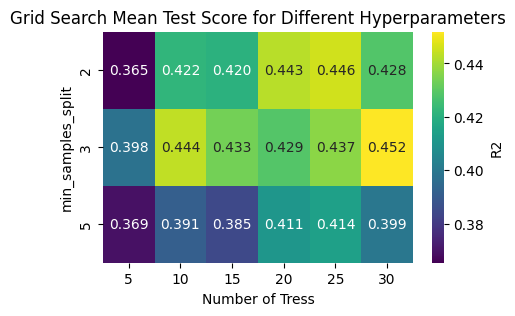

Best hyperparameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 10}


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Create a Random Forest Regressor
rf_model = RandomForestRegressor()

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [5, 10, 15, 20, 25, 30],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create GridSearchCV object
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='r2', verbose=1)

# Fit the model to the data
grid_search.fit(X_train, y_train)

# Extract results into a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Create a pivot table for heatmap visualization
heatmap_data = results.pivot_table(
    index='param_min_samples_leaf',
    columns='param_n_estimators',
    values='mean_test_score'
)

# Plotting the heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='.3f', cbar_kws={'label': 'R2'})
plt.title('Grid Search Mean Test Score for Different Hyperparameters')
plt.xlabel('Number of Trees')
plt.ylabel('Minimum Samples Leaf')
plt.show()

# Create a pivot table for heatmap visualization
heatmap_data = results.pivot_table(
    index='param_min_samples_split',
    columns='param_n_estimators',
    values='mean_test_score'
)

# Plotting the heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='.3f', cbar_kws={'label': 'R2'})
plt.title('Grid Search Mean Test Score for Different Hyperparameters')
plt.xlabel('Number of Tress')
plt.ylabel('min_samples_split')
plt.show()


# Get the best hyperparameters
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

print(f"Best hyperparameters: {best_params}")

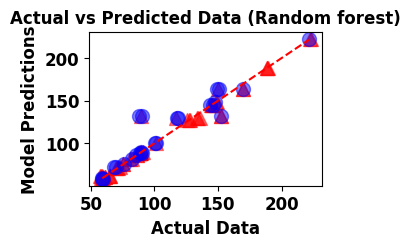

In [6]:
# Create a scatter plot for random forest results
import matplotlib.pyplot as plt

# Create a figure with a specified size
plt.figure(figsize=(3, 2))  # Adjust the width and height as needed

plt.scatter(y_train, y_pred_rfT, alpha=0.5, s = 100, c = 'red', marker = '^')
plt.scatter(y_test, y_pred_rf, alpha=0.5, s = 100, c = 'blue', marker = 'o')

# Plot the perfect prediction line (y = x)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')

# Set labels and title
plt.xlabel('Actual Data', fontsize = 12, fontweight='bold')
plt.ylabel('Model Predictions', fontsize = 12, fontweight='bold')
plt.title('Actual vs Predicted Data (Random forest)', fontsize = 12, fontweight='bold')

# Customize x and y-axis font size and style
#plt.xticks(fontsize=10, fontstyle='italic')  # Set font size and style for x-axis ticks
plt.xticks(fontsize=12, fontweight='bold')  # Set font size and style for x-axis ticks
plt.yticks(fontsize=12, fontweight='bold')   # Set font size and style for y-axis ticks

# Show the plot
plt.show()

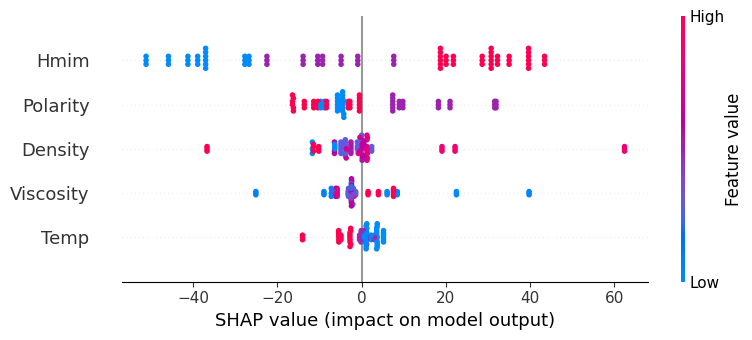

In [13]:
# SHapley Additive exPlanations (SHAP) with randome forest models
# If shap is not installed, run the first command below first and then comment it out
# !pip install shap

import shap
import matplotlib.pyplot as plt
import pandas as pd

# Custom feature names
feature_names = ['Hmim', 'Temp', 'Viscosity', 'Density', 'Polarity']

# Initialize SHAP explainer
explainer = shap.Explainer(best_rf_model.predict, X)
shap_values = explainer(X)

# Summary plot with custom feature names
shap.summary_plot(shap_values, X, feature_names=feature_names)

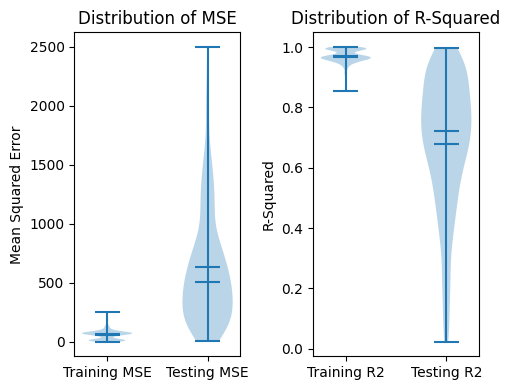

The total number of runs: len(mse_scores)
500


In [14]:
# Generate data for Violin plots -- Random forest regression.

# Initialize lists to store performance metrics
mse_scores = []
r2_scores = []

# Perform multiple trials
n_trials = 500

# Perform trials until we collect the required number of positive scores
while len(mse_scores) < n_trials:

    # Split the data into training and testing sets for each trial
    X_train_trial, X_test_trial, y_train_trial, y_test_trial = train_test_split(X_train, y_train, test_size=0.3, random_state=np.random.randint(0, 10000))

    # Train the model
    best_rf_model.fit(X_train_trial, y_train_trial)

    # Make predictions
    y_pred_train_trial = best_rf_model.predict(X_train_trial)
    y_pred_test_trial = best_rf_model.predict(X_test_trial)

    # Evaluate the model
    mse_train = mean_squared_error(y_train_trial, y_pred_train_trial)
    r2_train = r2_score(y_train_trial, y_pred_train_trial)
    mse_test = mean_squared_error(y_test_trial, y_pred_test_trial)
    r2_test = r2_score(y_test_trial, y_pred_test_trial)

    # Save only positive scores
    if mse_train > 0 and mse_test > 0 and r2_train > 0 and r2_test > 0:
        mse_scores.append([mse_train, mse_test])
        r2_scores.append([r2_train, r2_test])

# Convert lists to numpy arrays for easier plotting
mse_scores_rf = np.array(mse_scores)
r2_scores_rf = np.array(r2_scores)

# Create violin plots for MSE and R-squared scores
plt.figure(figsize=(5, 4))

# MSE distribution plot
plt.subplot(1, 2, 1)
plt.violinplot([mse_scores_rf[:, 0], mse_scores_rf[:, 1]], showmeans=True, showmedians=True)
plt.xticks([1, 2], ['Training MSE', 'Testing MSE'])
plt.ylabel('Mean Squared Error')
plt.title('Distribution of MSE')

# R-squared distribution plot
plt.subplot(1, 2, 2)
plt.violinplot([r2_scores_rf[:, 0], r2_scores_rf[:, 1]], showmeans=True, showmedians=True)
plt.xticks([1, 2], ['Training R2', 'Testing R2'])
plt.ylabel('R-Squared')
plt.title('Distribution of R-Squared')

plt.tight_layout()
plt.show()

print(f'The total number of runs: len(mse_scores)')
print(len(mse_scores))

In [15]:
# Support vector regression (SVR)
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

# Define the parameter grid for SVR
param_grid = {
    'kernel': ['rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 15],  # Regularization parameter
    'epsilon': [0.01, 0.1, 0.2],  # Epsilon in the epsilon-SVR model
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
}

# Create an SVR model
modelSVR = SVR()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=modelSVR, param_grid=param_grid, cv=5, scoring='r2', verbose=1)

# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train.ravel())

# Get the best model from GridSearchCV
best_model_svr = grid_search.best_estimator_

# Print the best parameters found
print(f"Best parameters found: {grid_search.best_params_}")

# Predict using the best model
y_pred_SVRT = best_model_svr.predict(X_train)

# Evaluate the model on training data
r_squared_trainSVR = r2_score(y_train, y_pred_SVRT)
mse_trainSVR = mean_squared_error(y_train, y_pred_SVRT)

print(f"R-squared on training data: {r_squared_trainSVR}")

print(f"MSE on training data: {mse_trainSVR}")

# Make predictions on testing data
y_pred_SVR = best_model_svr.predict(X_test)

# Evaluate the model on testing data
r_squared_SVRT = r2_score(y_test, y_pred_SVR)
mse_SVRT = mean_squared_error(y_test, y_pred_SVR)

print(f"R-squared on testing data: {r_squared_SVRT}")
print(f"MSE on testing data: {mse_SVRT}")

<ipython-input-15-2951e3c1a943>:21: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  grid_search.fit(X_train, y_train.ravel())


Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters found: {'C': 15, 'epsilon': 0.2, 'gamma': 1, 'kernel': 'rbf'}
R-squared on training data: 0.7739899646559893
MSE on training data: 453.0502808163169
R-squared on testing data: 0.6588304248303869
MSE on testing data: 558.459243925956


<ipython-input-25-2eb5b027baf3>:28: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  grid_search.fit(X_train, y_train.ravel())


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found: {'C': 30, 'epsilon': 5, 'gamma': 'auto', 'kernel': 'rbf'}
R-squared on training data: 0.8784920474776158
MSE on training data: 243.56976860735978
R-squared on testing data: 0.6417361681934508
MSE on testing data: 586.4407708021247
Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_epsilon', 'param_gamma', 'param_kernel', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')


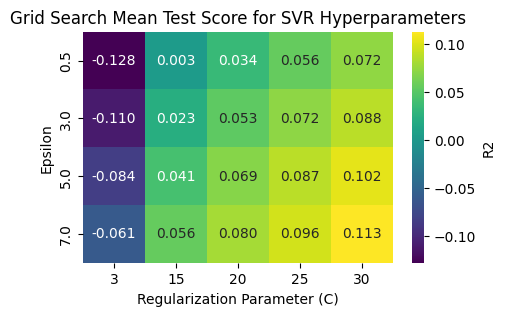

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

# Assuming X_train, y_train, X_test, and y_test are already defined

# Define the parameter grid for SVR
param_grid = {
    'kernel': ['rbf', 'sigmoid'],
    #'C': [0.1, 1, 3, 5, 10, 15],  # Regularization parameter
    'C': [3, 15, 20, 25, 30],  # Regularization parameter
    #'epsilon': [0.01, 0.1, 0.2, 0.25, 0.3],  # Epsilon in the epsilon-SVR model
    'epsilon': [0.5, 3, 5, 7],  # Epsilon in the epsilon-SVR model
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
}

# Create an SVR model
modelSVR = SVR()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=modelSVR, param_grid=param_grid, cv=5, scoring='r2', verbose=1)

# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train.ravel())

# Get the best model from GridSearchCV
best_model_svr = grid_search.best_estimator_

# Print the best parameters found
print(f"Best parameters found: {grid_search.best_params_}")

# Predict using the best model
y_pred_SVRT = best_model_svr.predict(X_train)

# Evaluate the model on training data
r_squared_trainSVR = r2_score(y_train, y_pred_SVRT)
mse_trainSVR = mean_squared_error(y_train, y_pred_SVRT)

print(f"R-squared on training data: {r_squared_trainSVR}")
print(f"MSE on training data: {mse_trainSVR}")

# Make predictions on testing data
y_pred_SVR = best_model_svr.predict(X_test)

# Evaluate the model on testing data
r_squared_SVRT = r2_score(y_test, y_pred_SVR)
mse_SVRT = mean_squared_error(y_test, y_pred_SVR)

print(f"R-squared on testing data: {r_squared_SVRT}")
print(f"MSE on testing data: {mse_SVRT}")

# Extract results into a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Check the columns of the results DataFrame
print(results.columns)

# Create a pivot table for heatmap visualization
heatmap_data = results.pivot_table(
    index='param_epsilon',          # Use epsilon for rows
    columns='param_C',              # Use C for columns
    values='mean_test_score'
)

# Plotting the heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='.3f', cbar_kws={'label': 'R2'})
plt.title('Grid Search Mean Test Score for SVR Hyperparameters')
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Epsilon')
plt.show()

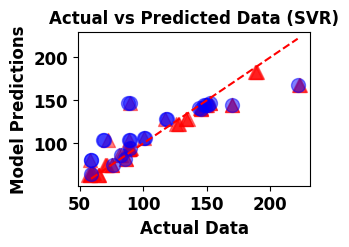

In [26]:
# Create a scatter plot
import matplotlib.pyplot as plt

# Create a figure with a specified size
plt.figure(figsize=(3, 2))  # Adjust the width and height as needed

plt.scatter(y_train, y_pred_SVRT, alpha=0.5, s = 100, c = 'red', marker = '^')
plt.scatter(y_test, y_pred_SVR, alpha=0.5, s = 100, c = 'blue', marker = 'o')

# Plot the perfect prediction line (y = x)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
# Set labels and title
plt.xlabel('Actual Data', fontsize = 12, fontweight='bold')
plt.ylabel('Model Predictions', fontsize = 12, fontweight='bold')
plt.title('Actual vs Predicted Data (SVR)', fontsize = 12, fontweight='bold')

# Customize x and y-axis font size and style
#plt.xticks(fontsize=10, fontstyle='italic')  # Set font size and style for x-axis ticks
plt.xticks(fontsize=12, fontweight='bold')  # Set font size and style for x-axis ticks
plt.yticks(fontsize=12, fontweight='bold')   # Set font size and style for y-axis ticks

# Show the plot
plt.show()

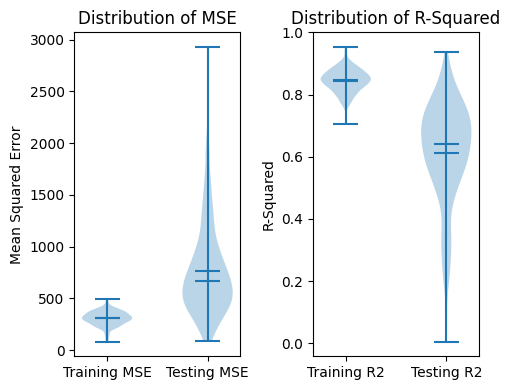

The total number of runs: len(mse_scores)
500


In [27]:
# Generate data for Violin plots -- SVR regression.

# Initialize lists to store performance metrics
mse_scores = []
r2_scores = []

# Perform multiple trials
n_trials = 500

# Perform trials until we collect the required number of positive scores
while len(mse_scores) < n_trials:

    # Split the data into training and testing sets for each trial
    X_train_trial, X_test_trial, y_train_trial, y_test_trial = train_test_split(X_train, y_train, test_size=0.3, random_state=np.random.randint(0, 10000))

    # Train the model
    best_model_svr.fit(X_train_trial, y_train_trial)

    # Make predictions
    y_pred_train_trial = best_model_svr.predict(X_train_trial)
    y_pred_test_trial = best_model_svr.predict(X_test_trial)

    # Evaluate the model
    mse_train = mean_squared_error(y_train_trial, y_pred_train_trial)
    r2_train = r2_score(y_train_trial, y_pred_train_trial)
    mse_test = mean_squared_error(y_test_trial, y_pred_test_trial)
    r2_test = r2_score(y_test_trial, y_pred_test_trial)

    # Save only positive scores
    if mse_train > 0 and mse_test > 0 and r2_train > 0 and r2_test > 0:
        mse_scores.append([mse_train, mse_test])
        r2_scores.append([r2_train, r2_test])

# Convert lists to numpy arrays for easier plotting
mse_scores_SVR = np.array(mse_scores)
r2_scores_SVR = np.array(r2_scores)

# Create violin plots for MSE and R-squared scores
plt.figure(figsize=(5, 4))

# MSE distribution plot
plt.subplot(1, 2, 1)
plt.violinplot([mse_scores_SVR[:, 0], mse_scores_SVR[:, 1]], showmeans=True, showmedians=True)
plt.xticks([1, 2], ['Training MSE', 'Testing MSE'])
plt.ylabel('Mean Squared Error')
plt.title('Distribution of MSE')

# R-squared distribution plot
plt.subplot(1, 2, 2)
plt.violinplot([r2_scores_SVR[:, 0], r2_scores_SVR[:, 1]], showmeans=True, showmedians=True)
plt.xticks([1, 2], ['Training R2', 'Testing R2'])
plt.ylabel('R-Squared')
plt.title('Distribution of R-Squared')

plt.tight_layout()
plt.show()

print(f'The total number of runs: len(mse_scores)')
print(len(mse_scores))

In [29]:
# Install Keras-tuner for hyperparameter tuning
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shutil
import os
import random

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import Callback
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

In [31]:
#pip install seaborn

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Best hyperparameters:
Number of units in the first hidden layer: 27
Number of hidden layers: 2
Number of units in hidden layer 1: 15
Number of units in hidden layer 2: 30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mean Squared Error for training: 218.78587775285988
R-squared for training: 0.8908558143378743
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Mean Squared Error for testing: 383.8802013589768
R-squared for testing: 0.7654828948788387


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


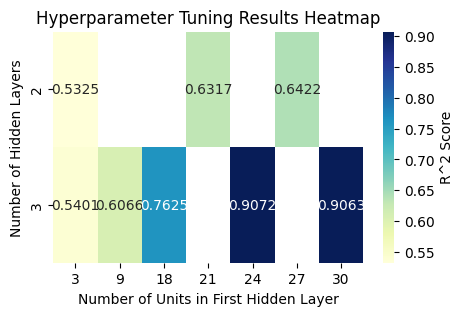

In [32]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras_tuner import HyperModel, RandomSearch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

# Clear the previous TensorFlow/Keras session
tf.keras.backend.clear_session()

# Clear previous results if needed
directory = 'hyperparam_tuning'
if os.path.exists(directory):
    shutil.rmtree(directory)

# Define a hypermodel
class RegressionHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Dense(hp.Int('units', min_value=3, max_value=30, step=3),
                        input_dim=5, activation='relu'))
        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(Dense(hp.Int(f'units_{i}', min_value=3, max_value=30, step=3),
                            activation='relu'))
        model.add(Dense(1, activation='linear'))
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
        return model

# Instantiate the tuner
tuner = RandomSearch(
    RegressionHyperModel(),
    objective='val_mean_squared_error',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='regression_tuning'
)

# Run the tuner and store the results
tuner.search(X_train, y_train, epochs=2000, validation_split=0.2, verbose=0)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best hyperparameters:")
print(f"Number of units in the first hidden layer: {best_hps.get('units')}")
print(f"Number of hidden layers: {best_hps.get('num_layers')}")
for i in range(best_hps.get('num_layers')):
    print(f"Number of units in hidden layer {i+1}: {best_hps.get(f'units_{i}')}")

# Build the model with the optimal hyperparameters and train it
nn_model = tuner.hypermodel.build(best_hps)
history = nn_model.fit(X_train, y_train, epochs=2000, validation_split=0.2, verbose=0)

# Make predictions -- training data
y_nn_predT = nn_model.predict(X_train)

# Calculate Mean Squared Error -- training data
mseTrain_nn = mean_squared_error(y_train, y_nn_predT)
print(f'Mean Squared Error for training: {mseTrain_nn}')

# Calculate R-squared
r2_nn_T = r2_score(y_train, y_nn_predT)
print(f'R-squared for training: {r2_nn_T}')

# Make predictions -- testing data
y_pred_nn = nn_model.predict(X_test)

# Calculate Mean Squared Error
mse_nnT = mean_squared_error(y_test, y_pred_nn)
print(f'Mean Squared Error for testing: {mse_nnT}')

# Calculate R-squared
r2_nn_test = r2_score(y_test, y_pred_nn)
print(f'R-squared for testing: {r2_nn_test}')

'''
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
'''
# Capture the results for heatmap visualization
results = tuner.oracle.get_best_trials(num_trials=10)
params = []
r2_scores = []  # Change to store R^2 scores

for trial in results:
    params.append((trial.hyperparameters.get('units'), trial.hyperparameters.get('num_layers')))
    # Calculate R^2 based on the best model for this trial
    model = tuner.hypermodel.build(trial.hyperparameters)
    model.fit(X_train, y_train, epochs=2000, validation_split=0.2, verbose=0)  # Fit the model again
    y_pred = model.predict(X_train)  # Predict on training data
    r2 = r2_score(y_train, y_pred)  # Calculate R^2
    r2_scores.append(r2)  # Store R^2 score

# Create a DataFrame for heatmap
df_results = pd.DataFrame(params, columns=['Units', 'Num_Layers'])
df_results['R2'] = r2_scores  # Change to store R^2 scores

# Pivot the DataFrame for heatmap using pivot_table
heatmap_data = df_results.pivot_table(index="Num_Layers", columns="Units", values="R2", aggfunc='mean')

# Plotting the heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="YlGnBu", cbar_kws={'label': 'R^2 Score'})
plt.title('Hyperparameter Tuning Results Heatmap')
plt.xlabel('Number of Units in First Hidden Layer')
plt.ylabel('Number of Hidden Layers')
plt.show()

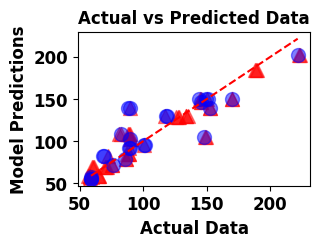

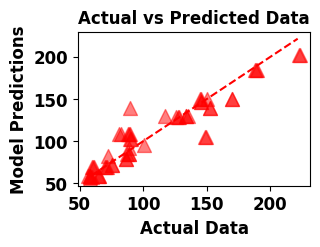

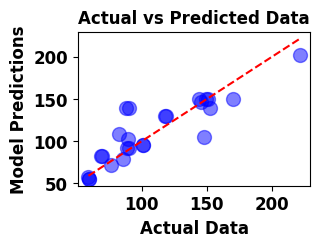

In [33]:
# Create a scatter plot
import matplotlib.pyplot as plt

# Create a figure with a specified size
plt.figure(figsize=(3, 2))  # Adjust the width and height as needed

plt.scatter(y_train, y_nn_predT, alpha=0.5, s = 100, c = 'red', marker = '^')
plt.scatter(y_test, y_pred_nn, alpha=0.5, s = 100, c = 'blue', marker = 'o')
# Plot the perfect prediction line (y = x)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
# Set labels and title
plt.xlabel('Actual Data', fontsize = 12, fontweight='bold')
plt.ylabel('Model Predictions', fontsize = 12, fontweight='bold')
plt.title('Actual vs Predicted Data', fontsize = 12, fontweight='bold')

# Customize x and y-axis font size and style
#plt.xticks(fontsize=10, fontstyle='italic')  # Set font size and style for x-axis ticks
plt.xticks(fontsize=12, fontweight='bold')  # Set font size and style for x-axis ticks
plt.yticks(fontsize=12, fontweight='bold')   # Set font size and style for y-axis ticks

# Show the plot
plt.show()

# Create a scatter plot
import matplotlib.pyplot as plt

# Create a figure with a specified size
plt.figure(figsize=(3, 2))  # Adjust the width and height as needed

plt.scatter(y_train, y_nn_predT, alpha=0.5, s = 100, c = 'red', marker = '^')
# Plot the perfect prediction line (y = x)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
# Set labels and title
plt.xlabel('Actual Data', fontsize = 12, fontweight='bold')
plt.ylabel('Model Predictions', fontsize = 12, fontweight='bold')
plt.title('Actual vs Predicted Data', fontsize = 12, fontweight='bold')

# Customize x and y-axis font size and style
#plt.xticks(fontsize=10, fontstyle='italic')  # Set font size and style for x-axis ticks
plt.xticks(fontsize=12, fontweight='bold')  # Set font size and style for x-axis ticks
plt.yticks(fontsize=12, fontweight='bold')   # Set font size and style for y-axis ticks

# Show the plot
plt.show()

# Create a scatter plot
import matplotlib.pyplot as plt

# Create a figure with a specified size
plt.figure(figsize=(3, 2))  # Adjust the width and height as needed

plt.scatter(y_test, y_pred_nn, alpha=0.5, s = 100, c = 'blue', marker = 'o')
# Plot the perfect prediction line (y = x)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
# Set labels and title
plt.xlabel('Actual Data', fontsize = 12, fontweight='bold')
plt.ylabel('Model Predictions', fontsize = 12, fontweight='bold')
plt.title('Actual vs Predicted Data', fontsize = 12, fontweight='bold')

# Customize x and y-axis font size and style
#plt.xticks(fontsize=10, fontstyle='italic')  # Set font size and style for x-axis ticks
plt.xticks(fontsize=12, fontweight='bold')  # Set font size and style for x-axis ticks
plt.yticks(fontsize=12, fontweight='bold')   # Set font size and style for y-axis ticks

# Show the plot
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━

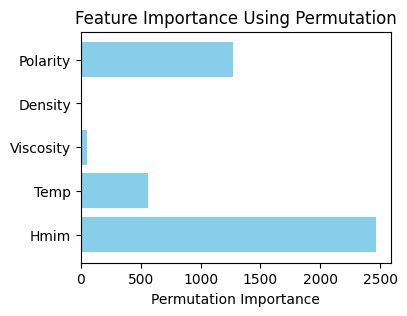

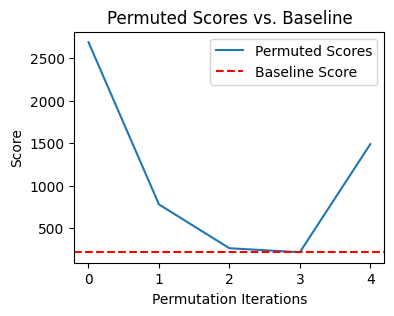

Baseline Score: 218.78587775285988
Permutation Scores: [2684.4994026298286, 781.0374498148975, 266.54614029518933, 219.83729007988444, 1488.0992318805281]
Feature Importances: [2465.7135248769687, 562.2515720620377, 47.76026254232946, 1.0514123270245648, 1269.3133541276682]


In [34]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Ensure X is a numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

# Function to calculate permutation importance
def permutation_importance(model, X, y, metric=mean_squared_error, n_repeats=10):
    # Ensure X and y are numpy arrays
    X = np.array(X)
    y = np.array(y)

    baseline_score = metric(y, model.predict(X))
    importances = []
    permuted_scores = []

    for i in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            np.random.shuffle(X_permuted[:, i])
            score = metric(y, model.predict(X_permuted))
            scores.append(score)
        mean_permuted_score = np.mean(scores)
        importances.append(mean_permuted_score - baseline_score)
        permuted_scores.append(mean_permuted_score)

    return importances, baseline_score, permuted_scores

# Calculate permutation importance
importances, baseline_score, permuted_scores = permutation_importance(nn_model, X_train, y_train)
features = ['Hmim', 'Temp', 'Viscosity', 'Density', 'Polarity']

# Plot feature importances
plt.figure(figsize=(4,3))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Permutation Importance')
plt.title('Feature Importance Using Permutation')
plt.show()

# Diagnostic Plot
plt.figure(figsize=(4, 3))
plt.plot(permuted_scores, label='Permuted Scores')
plt.axhline(y=baseline_score, color='r', linestyle='--', label='Baseline Score')
plt.xlabel('Permutation Iterations')
plt.ylabel('Score')
plt.title('Permuted Scores vs. Baseline')
plt.legend()
plt.show()

print("Baseline Score:", baseline_score)
print("Permutation Scores:", permuted_scores)
print("Feature Importances:", importances)

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
63/63 ━━━━━━━

ExactExplainer explainer:  32%|███▏      | 26/81 [00:00<?, ?it/s]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  35%|███▍      | 28/81 [00:10<00:07,  7.34it/s]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  36%|███▌      | 29/81 [00:10<00:11,  4.71it/s]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  37%|███▋      | 30/81 [00:11<00:12,  4.07it/s]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  38%|███▊      | 31/81 [00:11<00:13,  3.77it/s]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  40%|███▉      | 32/81 [00:11<00:13,  3.56it/s]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  41%|████      | 33/81 [00:11<00:13,  3.49it/s]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  42%|████▏     | 34/81 [00:12<00:13,  3.46it/s]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  43%|████▎     | 35/81 [00:12<00:13,  3.43it/s]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  44%|████▍     | 36/81 [00:12<00:13,  3.25it/s]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  46%|████▌     | 37/81 [00:13<00:13,  3.16it/s]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  47%|████▋     | 38/81 [00:13<00:13,  3.19it/s]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  48%|████▊     | 39/81 [00:13<00:12,  3.27it/s]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  49%|████▉     | 40/81 [00:14<00:12,  3.32it/s]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  51%|█████     | 41/81 [00:14<00:11,  3.36it/s]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  52%|█████▏    | 42/81 [00:14<00:11,  3.32it/s]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  53%|█████▎    | 43/81 [00:15<00:11,  3.20it/s]

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  54%|█████▍    | 44/81 [00:15<00:14,  2.64it/s]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  56%|█████▌    | 45/81 [00:16<00:15,  2.33it/s]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  57%|█████▋    | 46/81 [00:16<00:16,  2.11it/s]

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  58%|█████▊    | 47/81 [00:17<00:16,  2.02it/s]

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  59%|█████▉    | 48/81 [00:17<00:15,  2.15it/s]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  60%|██████    | 49/81 [00:18<00:15,  2.12it/s]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  62%|██████▏   | 50/81 [00:18<00:13,  2.33it/s]

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  63%|██████▎   | 51/81 [00:18<00:12,  2.49it/s]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  64%|██████▍   | 52/81 [00:19<00:10,  2.74it/s]

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  65%|██████▌   | 53/81 [00:19<00:09,  2.92it/s]

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  67%|██████▋   | 54/81 [00:19<00:09,  2.93it/s]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  68%|██████▊   | 55/81 [00:20<00:08,  2.94it/s]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  69%|██████▉   | 56/81 [00:20<00:08,  2.97it/s]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  70%|███████   | 57/81 [00:20<00:08,  2.96it/s]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  72%|███████▏  | 58/81 [00:20<00:07,  3.18it/s]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  73%|███████▎  | 59/81 [00:21<00:07,  3.14it/s]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  74%|███████▍  | 60/81 [00:21<00:06,  3.10it/s]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  75%|███████▌  | 61/81 [00:21<00:06,  3.20it/s]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  77%|███████▋  | 62/81 [00:22<00:05,  3.18it/s]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  78%|███████▊  | 63/81 [00:22<00:05,  3.42it/s]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  79%|███████▉  | 64/81 [00:22<00:05,  3.26it/s]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  80%|████████  | 65/81 [00:23<00:04,  3.31it/s]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  81%|████████▏ | 66/81 [00:23<00:04,  3.34it/s]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  83%|████████▎ | 67/81 [00:23<00:04,  3.33it/s]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  84%|████████▍ | 68/81 [00:23<00:03,  3.51it/s]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  85%|████████▌ | 69/81 [00:24<00:03,  3.64it/s]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  86%|████████▋ | 70/81 [00:24<00:03,  3.44it/s]

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  88%|████████▊ | 71/81 [00:24<00:03,  3.32it/s]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  89%|████████▉ | 72/81 [00:25<00:02,  3.48it/s]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  90%|█████████ | 73/81 [00:25<00:02,  3.66it/s]

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  91%|█████████▏| 74/81 [00:25<00:01,  3.51it/s]

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  93%|█████████▎| 75/81 [00:25<00:01,  3.54it/s]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  94%|█████████▍| 76/81 [00:26<00:01,  3.45it/s]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  95%|█████████▌| 77/81 [00:26<00:01,  3.30it/s]

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  96%|█████████▋| 78/81 [00:26<00:00,  3.26it/s]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  98%|█████████▊| 79/81 [00:27<00:00,  3.41it/s]

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  99%|█████████▉| 80/81 [00:27<00:00,  3.38it/s]

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer: 100%|██████████| 81/81 [00:27<00:00,  3.36it/s]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer: 82it [00:28,  2.00it/s]


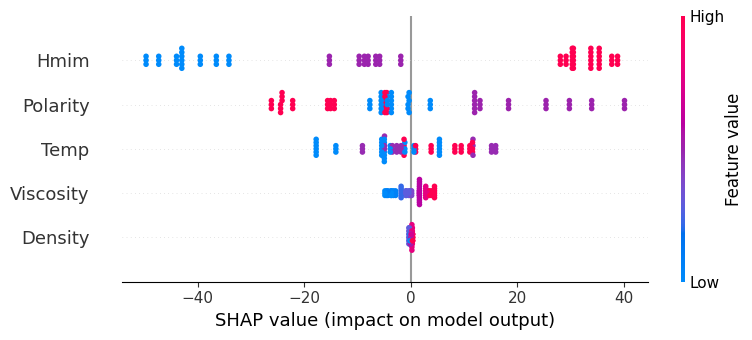

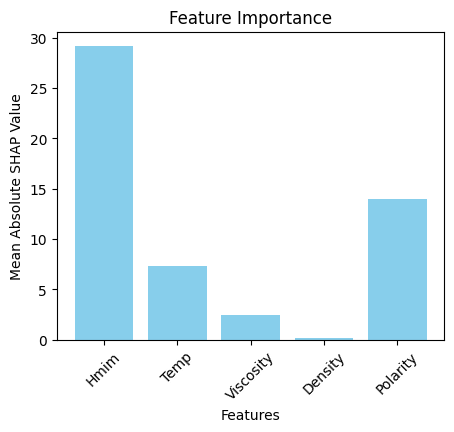

[29.14262472  7.32932476  2.46991663  0.18837796 13.92298318]


In [35]:
# Custom feature names
feature_names = ['Hmim', 'Temp', 'Viscosity', 'Density', 'Polarity']

# Initialize SHAP explainer
explainer = shap.Explainer(nn_model.predict, X)
shap_values = explainer(X)

# Summary plot with custom feature names
shap.summary_plot(shap_values, X, feature_names=feature_names)

# Bar plot of feature importances
# Enter column names
column_names = ['Hmim', 'Temp', 'Viscosity', 'Density', 'Polarity']

# Convert numpy array to DataFrame
X_df = pd.DataFrame(X, columns=column_names)

# Now you can use X_df.columns
importance = shap_values.abs.mean(0).values

# Create a bar plot with features on the x-axis and mean SHAP values on the y-axis
plt.figure(figsize=(5, 4))  # Optional: Adjust the figure size
plt.bar(column_names, importance, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Mean Absolute SHAP Value')
plt.title('Feature Importance')
plt.xticks(rotation=45)  # Optional: Rotate x-axis labels for better readability
plt.show()
print(shap_values.abs.mean(0).values)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 214.3193 - mean_squared_error: 214.3193 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 211.5198 - mean_squared_error: 211.5198 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 245.1992 - mean_squared_error: 245.1992 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 273.7301 - mean_squared_error: 273.7301 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 238.3314 - mean_squared_error: 238.3314 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 351.6706 - mean_squared_error: 351.6706 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s

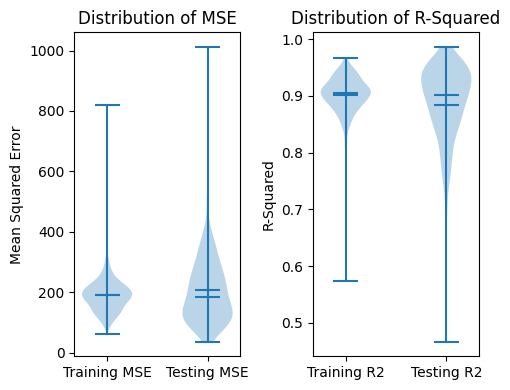

The total number of runs: len(mse_scores)
500


In [39]:
# Generate data for Violin plots -- neural network

# Initialize lists to store performance metrics
mse_scores = []
r2_scores = []

# Perform multiple trials
n_trials = 500

# Perform trials until we collect the required number of positive scores
while len(mse_scores) < n_trials:

    # Split the data into training and testing sets for each trial
    X_train_trial, X_test_trial, y_train_trial, y_test_trial = train_test_split(X_train, y_train, test_size=0.3, random_state=np.random.randint(0, 10000))

    # Train the model
    nn_model.fit(X_train_trial, y_train_trial)

    # Make predictions
    y_pred_train_trial = nn_model.predict(X_train_trial)
    y_pred_test_trial = nn_model.predict(X_test_trial)

    # Evaluate the model
    mse_train = mean_squared_error(y_train_trial, y_pred_train_trial)
    r2_train = r2_score(y_train_trial, y_pred_train_trial)
    mse_test = mean_squared_error(y_test_trial, y_pred_test_trial)
    r2_test = r2_score(y_test_trial, y_pred_test_trial)

    # Save only positive scores
    if mse_train > 0 and mse_test > 0 and r2_train > 0 and r2_test > 0:
        mse_scores.append([mse_train, mse_test])
        r2_scores.append([r2_train, r2_test])

# Convert lists to numpy arrays for easier plotting
mse_scores_NeN = np.array(mse_scores)
r2_scores_NeN = np.array(r2_scores)

# Create violin plots for MSE and R-squared scores
plt.figure(figsize=(5, 4))

# MSE distribution plot
plt.subplot(1, 2, 1)
plt.violinplot([mse_scores_NeN[:, 0], mse_scores_NeN[:, 1]], showmeans=True, showmedians=True)
plt.xticks([1, 2], ['Training MSE', 'Testing MSE'])
plt.ylabel('Mean Squared Error')
plt.title('Distribution of MSE')

# R-squared distribution plot
plt.subplot(1, 2, 2)
plt.violinplot([r2_scores_NeN[:, 0], r2_scores_NeN[:, 1]], showmeans=True, showmedians=True)
plt.xticks([1, 2], ['Training R2', 'Testing R2'])
plt.ylabel('R-Squared')
plt.title('Distribution of R-Squared')

plt.tight_layout()
plt.show()

print(f'The total number of runs: len(mse_scores)')
print(len(mse_scores))

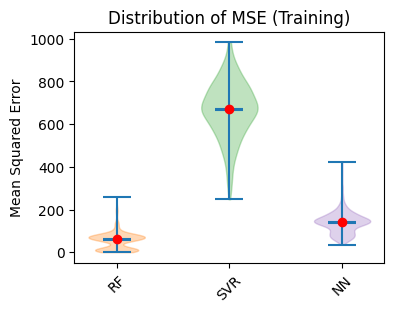

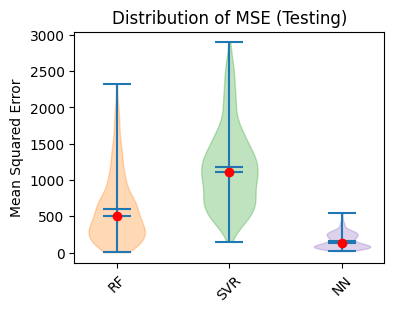

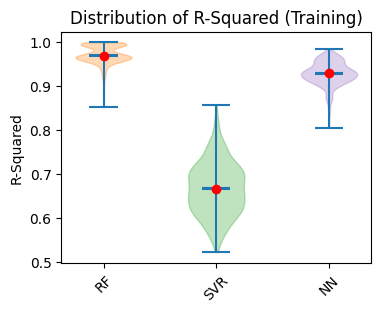

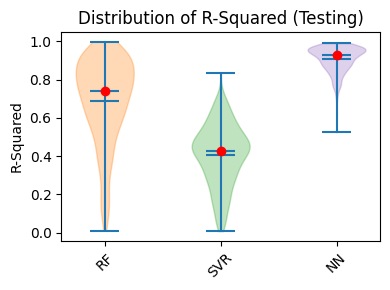

In [ ]:
# Create Violin plots for all approaches

# Define colors for each violin plot
colors = ['#ff7f0e', '#2ca02c','#9467bd']
# line_colors = ['#000000'] * 9  # Set all line colors to black for simplicity


# MSE  -- training
plt.figure(figsize=(4, 3))

# MSE distribution plot
# Create violin plots
violin_parts = plt.violinplot([mse_scores_rf[:, 0],  mse_scores_SVR[:, 0], mse_scores_NeN[:, 0]], showmeans=True, showmedians=True)

# Set colors for each violin plot
for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor(colors[i])

# Plot median markers
medians = [np.median(mse_scores_rf[:, 0]), np.median(mse_scores_SVR[:, 0]), np.median(mse_scores_NeN[:, 0])]
positions = range(1, 4)

plt.plot(positions, medians, 'o', color='red', label='Median')  # Marker for medians

plt.xticks([1, 2, 3], ['RF','SVR', 'NN'], rotation=45)
plt.ylabel('Mean Squared Error')
plt.title('Distribution of MSE (Training)')

# MSE  -- testing
plt.figure(figsize=(4, 3))

# MSE distribution plot
violin_parts = plt.violinplot([mse_scores_rf[:, 1], mse_scores_SVR[:, 1], mse_scores_NeN[:, 1]], showmeans=True, showmedians=True)

# Set colors for each violin plot
for i, pc in enumerate(violin_parts['bodies']):
    pc.set_edgecolor(colors[i])
    pc.set_facecolor(colors[i])

# Plot median markers
medians = [np.median(mse_scores_rf[:, 1]), np.median(mse_scores_SVR[:, 1]), np.median(mse_scores_NeN[:, 1])]
positions = range(1, 4)

plt.plot(positions, medians, 'o', color='red', label='Median')  # Marker for medians

plt.xticks([1, 2, 3], ['RF','SVR', 'NN'], rotation=45)
plt.ylabel('Mean Squared Error')
plt.title('Distribution of MSE (Testing)')


# R-squared distribution plot  -- training
plt.figure(figsize=(4, 3))

violin_parts = plt.violinplot([r2_scores_rf[:, 0], r2_scores_SVR[:, 0], r2_scores_NeN[:, 0]], showmeans=True, showmedians=True)

# Set colors for each violin plot
for i, pc in enumerate(violin_parts['bodies']):
    pc.set_edgecolor(colors[i])
    pc.set_facecolor(colors[i])

# Plot median markers
medians = [np.median(r2_scores_rf[:, 0]), np.median(r2_scores_SVR[:, 0]), np.median(r2_scores_NeN[:, 0])]
positions = range(1, 4)

plt.plot(positions, medians, 'o', color='red', label='Median')  # Marker for medians

plt.xticks([1, 2, 3], ['RF', 'SVR', 'NN'], rotation=45)
plt.ylabel('R-Squared')
plt.title('Distribution of R-Squared (Training)')

# R-squared distribution plot  -- testing
plt.figure(figsize=(4, 3))
violin_parts = plt.violinplot([r2_scores_rf[:, 1],  r2_scores_SVR[:, 1], r2_scores_NeN[:, 1]], showmeans=True, showmedians=True)

# Set colors for each violin plot
for i, pc in enumerate(violin_parts['bodies']):
    pc.set_edgecolor(colors[i])
    pc.set_facecolor(colors[i])

# Plot median markers
medians = [np.median(r2_scores_rf[:, 1]), np.median(r2_scores_SVR[:, 1]), np.median(r2_scores_NeN[:, 1])]
positions = range(1, 4)

plt.plot(positions, medians, 'o', color='red', label='Median')  # Marker for medians

plt.xticks([1, 2, 3], ['RF', 'SVR', 'NN'], rotation=45)

plt.ylabel('R-Squared')
plt.title('Distribution of R-Squared (Testing)')

plt.tight_layout()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


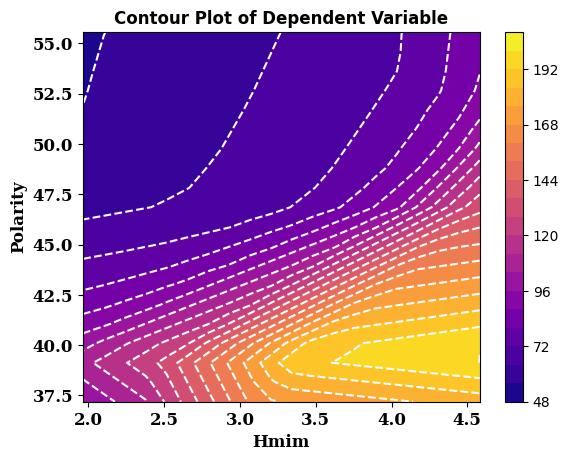

In [ ]:
# Using mean values of factors that are not considered for 2D plot -- neural network model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_excel('data_zif8.xlsx')

# Relationship between Factor1 (Hmim) and Factor5 (polarity)
# Create a grid for Factor1 and Factor5
factor1Range = np.linspace(np.min(data['Hmim']), np.max(data['Hmim']), 20)
factor5Range = np.linspace(np.min(data['Polarity']), np.max(data['Polarity']), 20)

factor1Grid, factor5Grid = np.meshgrid(factor1Range, factor5Range)

# Create a grid of input data for prediction
inputGrid = pd.DataFrame({
    'Hmim': factor1Grid.flatten(),
    'Temp': np.ones_like(factor1Grid.flatten()) * np.mean(data['Temp']),
    'Viscosity': np.ones_like(factor1Grid.flatten()) * np.mean(data['Viscosity']),
    'Density': np.ones_like(factor1Grid.flatten()) * np.mean(data['Density']),
    'Polarity': factor5Grid.flatten()
})

# Make predictions on the grid
predictions = nn_model.predict(inputGrid)

# Reshape predictions to match the grid dimensions
predictionsGrid = predictions.reshape(factor1Grid.shape)

# Create a 2D contour plot
plt.figure()

contourf = plt.contourf(factor1Grid, factor5Grid, predictionsGrid, 20, cmap='plasma')

# Add contour lines with custom line styles
contour = plt.contour(factor1Grid, factor5Grid, predictionsGrid, 20, colors='white', linestyles='dashed')

# Customize font and size for title, x-axis label, and y-axis label
plt.title('Contour Plot of Dependent Variable', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'sans-serif'})
plt.xlabel('Hmim', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'serif'})
plt.ylabel('Polarity', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'serif'})

# Show the colorbar
plt.colorbar(contourf)

# Customize font and size for x-axis and y-axis numbers
plt.xticks(fontsize=12, fontweight='bold', fontfamily='serif')
plt.yticks(fontsize=12, fontweight='bold', fontfamily='serif')

# Show the plot
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


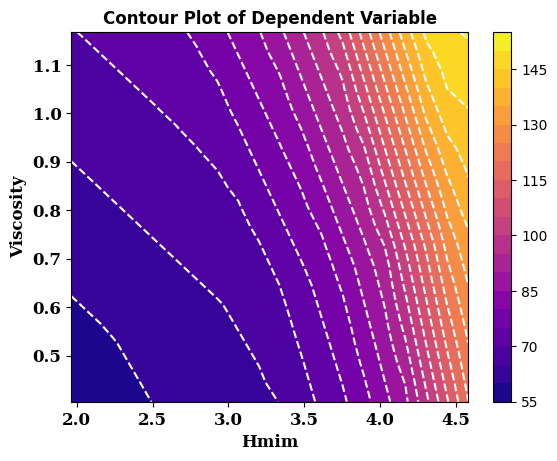

In [ ]:
# Using mean values of factors that are not considered for 2D plot.


# Relationship between Factor1 (Hmim) and Factor3 (viscosity)
# Create a grid for Factor1 and Factor5
factor1Range = np.linspace(np.min(data['Hmim']), np.max(data['Hmim']), 20)
factor3Range = np.linspace(np.min(data['Viscosity']), np.max(data['Viscosity']), 20)

factor1Grid, factor3Grid = np.meshgrid(factor1Range, factor3Range)


# Create a grid of input data for prediction
inputGrid = pd.DataFrame({
    'Hmim': factor1Grid.flatten(),
    'Temp': np.ones_like(factor1Grid.flatten()) * np.mean(data['Temp']),
    'Viscosity': factor3Grid.flatten(),
    'Density': np.ones_like(factor1Grid.flatten()) * np.mean(data['Density']),
    'Polarity': np.ones_like(factor1Grid.flatten()) * np.mean(data['Polarity'])
})

# Make predictions on the grid
predictions = nn_model.predict(inputGrid)

# Reshape predictions to match the grid dimensions
predictionsGrid = predictions.reshape(factor1Grid.shape)

# Create a 2D contour plot
plt.figure()

contourf = plt.contourf(factor1Grid, factor3Grid, predictionsGrid, 20, cmap='plasma')

# Add contour lines with custom line styles
contour = plt.contour(factor1Grid, factor3Grid, predictionsGrid, 20, colors='white', linestyles='dashed')

# Customize font and size for title, x-axis label, and y-axis label
plt.title('Contour Plot of Dependent Variable', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'sans-serif'})
plt.xlabel('Hmim', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'serif'})
plt.ylabel('Viscosity', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'serif'})

# Show the colorbar
plt.colorbar(contourf)

# Customize font and size for x-axis and y-axis numbers
plt.xticks(fontsize=12, fontweight='bold', fontfamily='serif')
plt.yticks(fontsize=12, fontweight='bold', fontfamily='serif')

# Show the plot
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


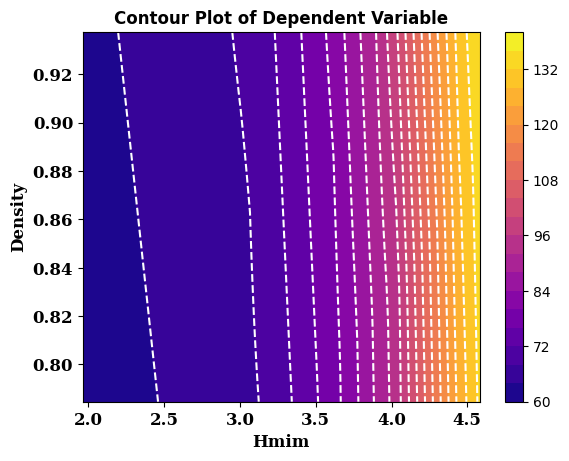

In [ ]:
# Using mean values of factors that are not considered for 2D plot.

# Relationship between Factor1 (Hmim) and Factor4 (density)
# Create a grid for Factor1 and Factor4
factor1Range = np.linspace(np.min(data['Hmim']), np.max(data['Hmim']), 20)
factor4Range = np.linspace(np.min(data['Density']), np.max(data['Density']), 20)

factor1Grid, factor4Grid = np.meshgrid(factor1Range, factor4Range)


# Create a grid of input data for prediction
inputGrid = pd.DataFrame({
    'Hmim': factor1Grid.flatten(),
    'Temp': np.ones_like(factor1Grid.flatten()) * np.mean(data['Temp']),
    'Viscosity': np.ones_like(factor1Grid.flatten()) * np.mean(data['Viscosity']),
    'Density': factor4Grid.flatten(),
    'Polarity': np.ones_like(factor1Grid.flatten()) * np.mean(data['Polarity'])
})

# Make predictions on the grid
predictions = nn_model.predict(inputGrid)

# Reshape predictions to match the grid dimensions
predictionsGrid = predictions.reshape(factor1Grid.shape)

# Create a 2D contour plot
plt.figure()

contourf = plt.contourf(factor1Grid, factor4Grid, predictionsGrid, 20, cmap='plasma')

# Add contour lines with custom line styles
contour = plt.contour(factor1Grid, factor4Grid, predictionsGrid, 20, colors='white', linestyles='dashed')

# Customize font and size for title, x-axis label, and y-axis label
plt.title('Contour Plot of Dependent Variable', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'sans-serif'})
plt.xlabel('Hmim', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'serif'})
plt.ylabel('Density', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'serif'})

# Show the colorbar
plt.colorbar(contourf)

# Customize font and size for x-axis and y-axis numbers
plt.xticks(fontsize=12, fontweight='bold', fontfamily='serif')
plt.yticks(fontsize=12, fontweight='bold', fontfamily='serif')

# Show the plot
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


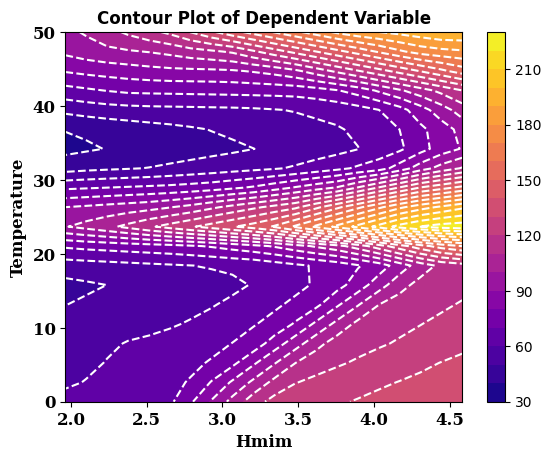

In [ ]:
# Using mean values of factors that are not considered for 2D plot.

# Relationship between Factor1 (Hmim) and Factor2 (temperature)
# Create a grid for Factor1 and Factor2
factor1Range = np.linspace(np.min(data['Hmim']), np.max(data['Hmim']), 20)
factor2Range = np.linspace(np.min(data['Temp']), np.max(data['Temp']), 20)

factor1Grid, factor2Grid = np.meshgrid(factor1Range, factor2Range)


# Create a grid of input data for prediction
inputGrid = pd.DataFrame({
    'Hmim': factor1Grid.flatten(),
    'Temp': factor2Grid.flatten(),
    'Viscosity': np.ones_like(factor1Grid.flatten()) * np.mean(data['Viscosity']),
    'Density': np.ones_like(factor1Grid.flatten()) * np.mean(data['Density']),
    'Polarity': np.ones_like(factor1Grid.flatten()) * np.mean(data['Polarity'])
})

# Make predictions on the grid
predictions = nn_model.predict(inputGrid)

# Reshape predictions to match the grid dimensions
predictionsGrid = predictions.reshape(factor1Grid.shape)

# Create a 2D contour plot
plt.figure()

contourf = plt.contourf(factor1Grid, factor2Grid, predictionsGrid, 20, cmap='plasma')

# Add contour lines with custom line styles
contour = plt.contour(factor1Grid, factor2Grid, predictionsGrid, 20, colors='white', linestyles='dashed')

# Customize font and size for title, x-axis label, and y-axis label
plt.title('Contour Plot of Dependent Variable', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'sans-serif'})
plt.xlabel('Hmim', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'serif'})
plt.ylabel('Temperature', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'serif'})

# Show the colorbar
plt.colorbar(contourf)

# Customize font and size for x-axis and y-axis numbers
plt.xticks(fontsize=12, fontweight='bold', fontfamily='serif')
plt.yticks(fontsize=12, fontweight='bold', fontfamily='serif')

# Show the plot
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


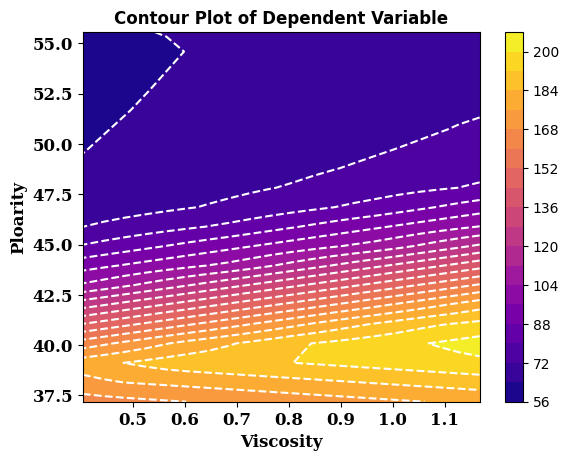

In [ ]:
# Using mean values of factors that are not considered for 2D plot.

# Relationship between Factor1 (Hmim) and Factor2 (temperature)
# Create a grid for Factor1 and Factor2
factor3Range = np.linspace(np.min(data['Viscosity']), np.max(data['Viscosity']), 20)
factor5Range = np.linspace(np.min(data['Polarity']), np.max(data['Polarity']), 20)
factor3Grid, factor5Grid = np.meshgrid(factor3Range, factor5Range)


# Create a grid of input data for prediction
inputGrid = pd.DataFrame({
    'Hmim': np.ones_like(factor3Grid.flatten()) * np.mean(data['Hmim']),
    'Temp': np.ones_like(factor3Grid.flatten()) * np.mean(data['Temp']),
    'Viscosity': factor3Grid.flatten(),
    'Density': np.ones_like(factor3Grid.flatten()) * np.mean(data['Density']),
    'Polarity': factor5Grid.flatten(),
})


# Make predictions on the grid
predictions = nn_model.predict(inputGrid)

# Reshape predictions to match the grid dimensions
predictionsGrid = predictions.reshape(factor3Grid.shape)

# Create a 2D contour plot
plt.figure()

contourf = plt.contourf(factor3Grid, factor5Grid, predictionsGrid, 20, cmap='plasma')

# Add contour lines with custom line styles
contour = plt.contour(factor3Grid, factor5Grid, predictionsGrid, 20, colors='white', linestyles='dashed')

# Customize font and size for title, x-axis label, and y-axis label
plt.title('Contour Plot of Dependent Variable', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'sans-serif'})
plt.xlabel('Viscosity', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'serif'})
plt.ylabel('Ploarity', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'serif'})

# Show the colorbar
plt.colorbar(contourf)

# Customize font and size for x-axis and y-axis numbers
plt.xticks(fontsize=12, fontweight='bold', fontfamily='serif')
plt.yticks(fontsize=12, fontweight='bold', fontfamily='serif')

# Show the plot
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


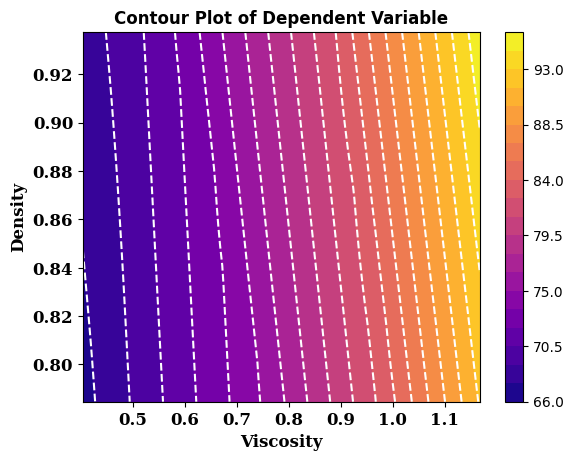

In [ ]:
# Using mean values of factors that are not considered for 2D plot.

# Relationship between Factor1 (Hmim) and Factor2 (temperature)
# Create a grid for Factor1 and Factor2
factor3Range = np.linspace(np.min(data['Viscosity']), np.max(data['Viscosity']), 20)
factor4Range = np.linspace(np.min(data['Density']), np.max(data['Density']), 20)
factor3Grid, factor4Grid = np.meshgrid(factor3Range, factor4Range)


# Create a grid of input data for prediction
inputGrid = pd.DataFrame({
    'Hmim': np.ones_like(factor3Grid.flatten()) * np.mean(data['Hmim']),
    'Temp': np.ones_like(factor3Grid.flatten()) * np.mean(data['Temp']),
    'Viscosity': factor3Grid.flatten(),
    'Density': factor4Grid.flatten(),
    'Polarity': np.ones_like(factor3Grid.flatten()) * np.mean(data['Polarity']),
})

# Make predictions on the grid
predictions = nn_model.predict(inputGrid)

# Reshape predictions to match the grid dimensions
predictionsGrid = predictions.reshape(factor3Grid.shape)

# Create a 2D contour plot
plt.figure()

contourf = plt.contourf(factor3Grid, factor4Grid, predictionsGrid, 20, cmap='plasma')

# Add contour lines with custom line styles
contour = plt.contour(factor3Grid, factor4Grid, predictionsGrid, 20, colors='white', linestyles='dashed')

# Customize font and size for title, x-axis label, and y-axis label
plt.title('Contour Plot of Dependent Variable', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'sans-serif'})
plt.xlabel('Viscosity', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'serif'})
plt.ylabel('Density', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'serif'})

# Show the colorbar
plt.colorbar(contourf)

# Customize font and size for x-axis and y-axis numbers
plt.xticks(fontsize=12, fontweight='bold', fontfamily='serif')
plt.yticks(fontsize=12, fontweight='bold', fontfamily='serif')

# Show the plot
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


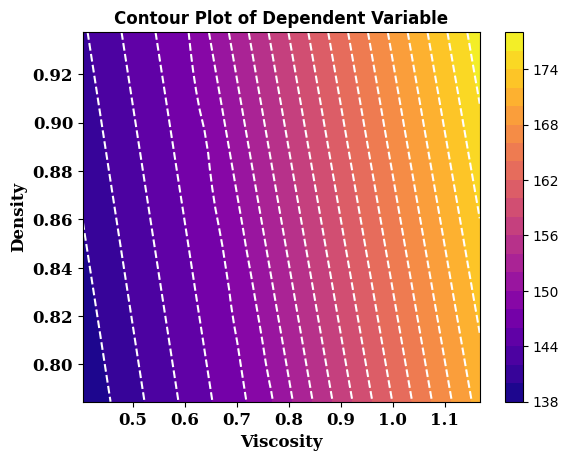

In [ ]:
# Using mean values of factors that are not considered for 2D plot.

# Relationship between Factor1 (Hmim) and Factor2 (temperature)
# Create a grid for Factor1 and Factor2
factor3Range = np.linspace(np.min(data['Viscosity']), np.max(data['Viscosity']), 20)
factor4Range = np.linspace(np.min(data['Density']), np.max(data['Density']), 20)
factor3Grid, factor4Grid = np.meshgrid(factor3Range, factor4Range)


# Create a grid of input data for prediction
inputGrid = pd.DataFrame({
    'Hmim': np.ones_like(factor3Grid.flatten()) * np.median(data['Hmim']),
    'Temp': np.ones_like(factor3Grid.flatten()) * np.median(data['Temp']),
    'Viscosity': factor3Grid.flatten(),
    'Density': factor4Grid.flatten(),
    'Polarity': np.ones_like(factor3Grid.flatten()) * np.median(data['Polarity']),
})

# Make predictions on the grid
predictions = nn_model.predict(inputGrid)

# Reshape predictions to match the grid dimensions
predictionsGrid = predictions.reshape(factor3Grid.shape)

# Create a 2D contour plot
plt.figure()

contourf = plt.contourf(factor3Grid, factor4Grid, predictionsGrid, 20, cmap='plasma')

# Add contour lines with custom line styles
contour = plt.contour(factor3Grid, factor4Grid, predictionsGrid, 20, colors='white', linestyles='dashed')

# Customize font and size for title, x-axis label, and y-axis label
plt.title('Contour Plot of Dependent Variable', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'sans-serif'})
plt.xlabel('Viscosity', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'serif'})
plt.ylabel('Density', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'serif'})

# Show the colorbar
plt.colorbar(contourf)

# Customize font and size for x-axis and y-axis numbers
plt.xticks(fontsize=12, fontweight='bold', fontfamily='serif')
plt.yticks(fontsize=12, fontweight='bold', fontfamily='serif')

# Show the plot
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


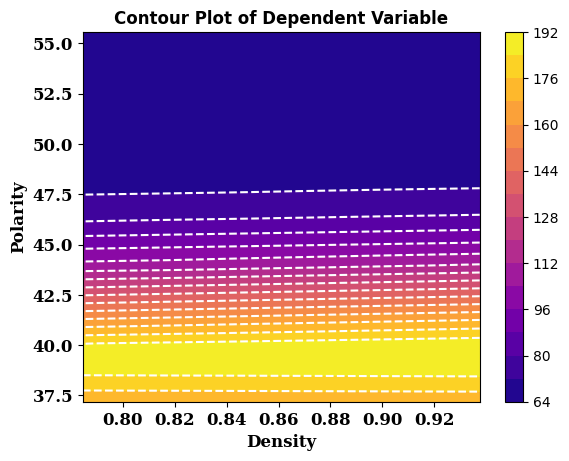

In [ ]:
# Using mean values of factors that are not considered for 2D plot.

# Relationship between Factor1 (Hmim) and Factor2 (temperature)
# Create a grid for Factor1 and Factor2
factor4Range = np.linspace(np.min(data['Density']), np.max(data['Density']), 20)
factor5Range = np.linspace(np.min(data['Polarity']), np.max(data['Polarity']), 20)
factor4Grid, factor5Grid = np.meshgrid(factor4Range, factor5Range)


# Create a grid of input data for prediction
inputGrid = pd.DataFrame({
    'Hmim': np.ones_like(factor4Grid.flatten()) * np.mean(data['Hmim']),
    'Temp': np.ones_like(factor4Grid.flatten()) * np.mean(data['Temp']),
    'Viscosity': np.ones_like(factor4Grid.flatten()) * np.mean(data['Viscosity']),
    'Density': factor4Grid.flatten(),
    'Polarity': factor5Grid.flatten(),
})

# Make predictions on the grid
predictions = nn_model.predict(inputGrid)

# Reshape predictions to match the grid dimensions
predictionsGrid = predictions.reshape(factor4Grid.shape)

# Create a 2D contour plot
plt.figure()

contourf = plt.contourf(factor4Grid, factor5Grid, predictionsGrid, 20, cmap='plasma')

# Add contour lines with custom line styles
contour = plt.contour(factor4Grid, factor5Grid, predictionsGrid, 20, colors='white', linestyles='dashed')

# Customize font and size for title, x-axis label, and y-axis label
plt.title('Contour Plot of Dependent Variable', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'sans-serif'})
plt.xlabel('Density', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'serif'})
plt.ylabel('Polarity', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'serif'})

# Show the colorbar
plt.colorbar(contourf)

# Customize font and size for x-axis and y-axis numbers
plt.xticks(fontsize=12, fontweight='bold', fontfamily='serif')
plt.yticks(fontsize=12, fontweight='bold', fontfamily='serif')

# Show the plot
plt.show()